In [28]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd

In [2]:
train_path = '/kaggle/input/adobetraindata/behaviour_simulation_train.csv'
test_path = '/kaggle/input/inter-iit-mid-prep-adobe/problem_1_test_dataset/behaviour_simulation_test_company.xlsx'

In [3]:
test_dataset = pd.read_excel(test_path)

In [4]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                10000 non-null  int64 
 1   date              10000 non-null  object
 2   content           10000 non-null  object
 3   username          10000 non-null  object
 4   media             10000 non-null  object
 5   inferred company  10000 non-null  object
dtypes: int64(1), object(5)
memory usage: 468.9+ KB


In [5]:
train_dataset = pd.read_csv(train_path)

In [6]:
Photo_data = train_dataset[train_dataset['media'].apply(lambda x: x.startswith('[Photo'))].copy().reset_index(drop=True)

In [35]:
# img_links = Photo_data['media'].apply(lambda x:x.split("Photo(previewUrl")[1].split("'")[1])

In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
import pickle
with open('/kaggle/input/image-data-adobe/image_data.pkl','rb') as f:
    image_data = pickle.load(f)

In [9]:
valid_idxs = []
for i,_ in enumerate(image_data):
    if _ is not None:
        valid_idxs.append(i)
Photo_data = Photo_data.iloc[valid_idxs].reset_index(drop=True)
image_data = np.array(image_data)[valid_idxs]


In [10]:
!pip install vaderSentiment

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from transformers import BertTokenizer, BertModel
import torch
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def get_bert_cls_embedding(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy().squeeze()

def get_basic_features(text):
    return {
        'word_count': len(text.split()),
        'char_count': len(text),
        'hashtag_count': text.count('#'),
        'mention_count': text.count('<mention>'),
        'adtharate': text.count('@'),
        'emoji_count': sum(emoji.is_emoji(c) for c in text),
        'url_count': text.count('<hyperlink>')
    }

def get_datetime_features(dt):
    dt = datetime.strptime(dt,'%Y-%m-%d %H:%M:%S')
    return {
        'hour': dt.hour,
        'day': dt.day,
        'month': dt.month,
        'day_of_week': dt.weekday(),
        'is_weekend': dt.weekday() >= 5
    }

In [12]:
def process_tweets(df, text_column, datetime_column, company_column, likes_column, sample_size=1000):
    # Sample a subset of the data
    if sample_size is not None: df = df.copy().sample(n=min(sample_size, len(df)), random_state=42).reset_index(drop=True)
    else: df = df.copy().reset_index(drop=True)
    
    # Initialize BERT
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    
    # Initialize VADER
    sid = SentimentIntensityAnalyzer()
    
    # Extract features
#     df['bert_embedding'] = df[text_column].apply(lambda x: get_bert_cls_embedding(x, tokenizer, model))
    print('ok0')
    df['sentiment'] = df[text_column].apply(lambda x: sid.polarity_scores(x)['compound'])
    print('ok1')
    
    basic_features = df[text_column].apply(get_basic_features)
    df = pd.concat([df, pd.DataFrame(basic_features.tolist())], axis=1)
    
    print('ok1')
    datetime_features = df[datetime_column].apply(get_datetime_features)
    df = pd.concat([df, pd.DataFrame(datetime_features.tolist())], axis=1)
    
    print('ok2')
    # Prepare features and target
    feature_columns = ['sentiment', 'word_count', 'char_count', 'hashtag_count', 'mention_count', 'url_count', 'adtharate','emoji_count',
                       'hour', 'day', 'month', 'day_of_week', 'is_weekend']
    X = df[feature_columns].copy()
    y = df[likes_column].copy()
    groups = df[company_column].copy()
    
    print('ok2')
    # Add BERT embeddings to features
#     bert_embeddings = np.stack(df['bert_embedding'].values)
#     X = np.hstack([X, bert_embeddings])
    X = np.hstack([X]).astype(float)
    y = np.hstack([y]).astype(float)

    
    import pickle
    with open('nice_dataframe_adobe.pkl','wb') as f:
        pickle.dump([X,y,groups,df],f)
    
    return X, y, groups, df

In [13]:
import emoji
from datetime import datetime

In [14]:
X,y,groups,df = process_tweets(Photo_data, 'content', 'date', 'inferred company', 'likes', sample_size=1000)

ok0
ok1
ok1
ok2
ok2


In [15]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from io import BytesIO

In [16]:
class Custom_dataset(Dataset):
    def __init__(self, image_data, X,y=None, transform=None):
        self.image_data = image_data
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        img = Image.open(BytesIO(self.image_data[idx])).convert('RGB')

        # Convert RGBA to RGB if the image has 4 channels
#         if img.mode == 'RGBA':
#         img = img.convert('RGB')

        if self.transform:
            img = self.transform(img)

        if self.y is not None:
            y = torch.tensor(self.y[idx],dtype=torch.float32)
            return {
                'x': x,
                'y': y,
                'img': img
            }
        else:
            return {
                'x': x,
                'img': img
            }


In [17]:
from torchvision.transforms import v2
transforms = v2.Compose([
    v2.ToImage(),  
    v2.ToDtype(torch.uint8, scale=True), 
    v2.Resize(size=(224, 224), antialias=True),  
    v2.ToDtype(torch.float32, scale=True), 
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [18]:
from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 42)
split = splitter.split(X, groups=df['inferred company'])
train_inds, test_inds = next(split)

train_x,train_y,train_img = X[train_inds],y[train_inds],image_data[train_inds]
val_x,val_y,val_img = X[test_inds],y[test_inds],image_data[test_inds]

In [19]:

train = Custom_dataset(train_img,train_x,train_y,transforms)
val = Custom_dataset(val_img,val_x,val_y,transforms)


In [21]:
torch.manual_seed(42)
train_loader= DataLoader(train,batch_size=32,num_workers=4,shuffle=True)
val_loader= DataLoader(val,batch_size=32,num_workers=4,shuffle=False)

In [22]:
from torch import nn

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

class CustomNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CustomNeuralNetwork, self).__init__()
        
        self.tensor_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Load pre-trained EfficientNet
        self.efficientnet = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        
        # Replace last layer of EfficientNet
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(num_ftrs, hidden_dim)
        )
        
        # Combined network
        self.combined_net = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x, img):
        x = self.tensor_net(x)
        
        img_features = self.efficientnet(img)
        
        combined = torch.cat((x, img_features), dim=1)
        output = self.combined_net(combined)
        return output

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

def train_and_evaluate(model, train_loader, val_loader, num_epochs, learning_rate, device):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_rmse_history = []
    val_rmse_history = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_predictions = []
        train_targets = []
        
        # Training loop
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            x, img, y = batch['x'].to(device), batch['img'].to(device), batch['y'].to(device)
            
            optimizer.zero_grad()
            outputs = model(x, img)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_predictions.extend(outputs.detach().cpu().numpy())
            train_targets.extend(y.detach().cpu().numpy())
        
        train_rmse = np.sqrt(np.mean((np.array(train_predictions) - np.array(train_targets))**2))
        train_rmse_history.append(train_rmse)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                x, img, y = batch['x'].to(device), batch['img'].to(device), batch['y'].to(device)
                
                outputs = model(x, img)
                loss = criterion(outputs, y)
                
                val_loss += loss.item()
                val_predictions.extend(outputs.cpu().numpy())
                val_targets.extend(y.cpu().numpy())
        
        val_rmse = np.sqrt(np.mean((np.array(val_predictions) - np.array(val_targets))**2))
        val_rmse_history.append(val_rmse)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train RMSE: {train_rmse:.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val RMSE: {val_rmse:.4f}")
        print("--------------------")
    
    return train_rmse_history, val_rmse_history

In [25]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)
# Assuming you have already defined your model and data loaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = next(iter(train_loader))['x'].shape[1]
model = CustomNeuralNetwork(input_dim=input_dim, hidden_dim=256, output_dim=1).to(device)

num_epochs = 50
learning_rate = 0.001

In [26]:
train_rmse_history, val_rmse_history = train_and_evaluate(model, train_loader, val_loader, num_epochs, learning_rate, device)

# Output validation statistics
final_val_rmse = val_rmse_history[-1]
best_val_rmse = min(val_rmse_history)
best_epoch = val_rmse_history.index(best_val_rmse) + 1

print("\nValidation Statistics:")
print(f"Final Validation RMSE: {final_val_rmse:.4f}")
print(f"Best Validation RMSE: {best_val_rmse:.4f} (Epoch {best_epoch})")

Epoch 1/50 - Training:   0%|          | 0/25 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/50 - Training:  96%|█████████▌| 24/25 [00:06<00:00,  7.64it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in

Epoch 1/50
Train Loss: 20535157.1825, Train RMSE: 4548.2373
Val Loss: 916171.4286, Val RMSE: 961.5967
--------------------


Epoch 2/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 2/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


Epoch 2/50
Train Loss: 20256904.9400, Train RMSE: 4517.0269
Val Loss: 811096.5000, Val RMSE: 905.1454
--------------------


Epoch 3/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 3/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


Epoch 3/50
Train Loss: 20450898.3869, Train RMSE: 4521.0537
Val Loss: 696237.5357, Val RMSE: 839.0588
--------------------


Epoch 4/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 4/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]


Epoch 4/50
Train Loss: 20279349.1125, Train RMSE: 4513.7749
Val Loss: 896444.1429, Val RMSE: 952.2593
--------------------


Epoch 5/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 5/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


Epoch 5/50
Train Loss: 20788028.7175, Train RMSE: 4509.4927
Val Loss: 588575.7232, Val RMSE: 775.9115
--------------------


Epoch 6/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 6/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


Epoch 6/50
Train Loss: 20234668.8775, Train RMSE: 4508.3389
Val Loss: 724124.9062, Val RMSE: 856.1413
--------------------


Epoch 7/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 7/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]


Epoch 7/50
Train Loss: 20113228.5850, Train RMSE: 4507.6191
Val Loss: 703179.4643, Val RMSE: 846.4752
--------------------


Epoch 8/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 8/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]


Epoch 8/50
Train Loss: 20145984.0675, Train RMSE: 4507.9189
Val Loss: 612176.6250, Val RMSE: 791.2878
--------------------


Epoch 9/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 9/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


Epoch 9/50
Train Loss: 20124504.1163, Train RMSE: 4507.7031
Val Loss: 938481.7143, Val RMSE: 974.4352
--------------------


Epoch 10/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 10/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


Epoch 10/50
Train Loss: 20104764.5700, Train RMSE: 4506.0820
Val Loss: 725845.4643, Val RMSE: 857.7289
--------------------


Epoch 11/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 11/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


Epoch 11/50
Train Loss: 20187121.8438, Train RMSE: 4506.9429
Val Loss: 635778.1696, Val RMSE: 804.8867
--------------------


Epoch 12/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 12/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


Epoch 12/50
Train Loss: 20224204.2350, Train RMSE: 4509.3013
Val Loss: 483682.6696, Val RMSE: 706.8938
--------------------


Epoch 13/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 13/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch 13/50
Train Loss: 20180186.4662, Train RMSE: 4508.5146
Val Loss: 662672.0089, Val RMSE: 821.6584
--------------------


Epoch 14/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 14/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


Epoch 14/50
Train Loss: 20104803.4875, Train RMSE: 4505.5435
Val Loss: 778176.7143, Val RMSE: 887.8456
--------------------


Epoch 15/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 15/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


Epoch 15/50
Train Loss: 22195347.5888, Train RMSE: 4506.2607
Val Loss: 701119.4107, Val RMSE: 844.1406
--------------------


Epoch 16/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 16/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]


Epoch 16/50
Train Loss: 20130997.5950, Train RMSE: 4506.2339
Val Loss: 640057.1964, Val RMSE: 808.5398
--------------------


Epoch 17/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 17/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch 17/50
Train Loss: 20282115.4000, Train RMSE: 4506.7739
Val Loss: 670218.4732, Val RMSE: 825.1932
--------------------


Epoch 18/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 18/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


Epoch 18/50
Train Loss: 20191529.8175, Train RMSE: 4508.1318
Val Loss: 710687.7143, Val RMSE: 849.8385
--------------------


Epoch 19/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 19/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]


Epoch 19/50
Train Loss: 20156010.0725, Train RMSE: 4506.1646
Val Loss: 714677.9107, Val RMSE: 852.0854
--------------------


Epoch 20/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 20/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


Epoch 20/50
Train Loss: 20112964.3188, Train RMSE: 4506.5610
Val Loss: 642803.7946, Val RMSE: 809.1625
--------------------


Epoch 21/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 21/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]


Epoch 21/50
Train Loss: 20118611.5775, Train RMSE: 4506.1152
Val Loss: 676107.1339, Val RMSE: 830.1052
--------------------


Epoch 22/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 22/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


Epoch 22/50
Train Loss: 20788667.0025, Train RMSE: 4506.2207
Val Loss: 536786.6607, Val RMSE: 741.0468
--------------------


Epoch 23/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 23/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]


Epoch 23/50
Train Loss: 20122073.1925, Train RMSE: 4505.5493
Val Loss: 747028.3482, Val RMSE: 870.9146
--------------------


Epoch 24/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 24/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


Epoch 24/50
Train Loss: 20197490.9125, Train RMSE: 4506.5703
Val Loss: 466989.7500, Val RMSE: 691.8495
--------------------


Epoch 25/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 25/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


Epoch 25/50
Train Loss: 20120670.6075, Train RMSE: 4510.8335
Val Loss: 803387.7679, Val RMSE: 902.3339
--------------------


Epoch 26/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 26/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]


Epoch 26/50
Train Loss: 20093062.5150, Train RMSE: 4505.8608
Val Loss: 851252.1696, Val RMSE: 928.2631
--------------------


Epoch 27/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 27/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]


Epoch 27/50
Train Loss: 22372548.9537, Train RMSE: 4506.3403
Val Loss: 590514.7455, Val RMSE: 776.2155
--------------------


Epoch 28/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 28/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]


Epoch 28/50
Train Loss: 20160166.7575, Train RMSE: 4506.1958
Val Loss: 855528.6875, Val RMSE: 930.5694
--------------------


Epoch 29/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 29/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


Epoch 29/50
Train Loss: 22354235.3150, Train RMSE: 4505.2988
Val Loss: 562137.3438, Val RMSE: 757.8285
--------------------


Epoch 30/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 30/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


Epoch 30/50
Train Loss: 20138693.9625, Train RMSE: 4505.0215
Val Loss: 740111.9911, Val RMSE: 866.8159
--------------------


Epoch 31/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 31/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


Epoch 31/50
Train Loss: 22190358.8263, Train RMSE: 4505.4761
Val Loss: 587096.0670, Val RMSE: 774.2495
--------------------


Epoch 32/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 32/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


Epoch 32/50
Train Loss: 20102226.4850, Train RMSE: 4505.2295
Val Loss: 924954.4107, Val RMSE: 967.3741
--------------------


Epoch 33/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 33/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]


Epoch 33/50
Train Loss: 20440697.5725, Train RMSE: 4508.1953
Val Loss: 600960.1384, Val RMSE: 782.8619
--------------------


Epoch 34/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 34/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


Epoch 34/50
Train Loss: 20166255.9112, Train RMSE: 4509.8823
Val Loss: 674795.8616, Val RMSE: 828.0350
--------------------


Epoch 35/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 35/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


Epoch 35/50
Train Loss: 20134606.6475, Train RMSE: 4506.3452
Val Loss: 862886.7857, Val RMSE: 934.4448
--------------------


Epoch 36/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 36/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


Epoch 36/50
Train Loss: 22180120.2625, Train RMSE: 4505.1206
Val Loss: 630528.6384, Val RMSE: 801.7607
--------------------


Epoch 37/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 37/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


Epoch 37/50
Train Loss: 20183620.2750, Train RMSE: 4510.1045
Val Loss: 738856.3125, Val RMSE: 865.7938
--------------------


Epoch 38/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 38/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]


Epoch 38/50
Train Loss: 20107440.9875, Train RMSE: 4508.4751
Val Loss: 544485.9688, Val RMSE: 745.9742
--------------------


Epoch 39/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 39/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]


Epoch 39/50
Train Loss: 20088685.0637, Train RMSE: 4505.2998
Val Loss: 759214.0446, Val RMSE: 877.6904
--------------------


Epoch 40/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 40/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


Epoch 40/50
Train Loss: 20291037.5375, Train RMSE: 4508.8423
Val Loss: 669693.7098, Val RMSE: 825.6265
--------------------


Epoch 41/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 41/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


Epoch 41/50
Train Loss: 20144720.4325, Train RMSE: 4509.6826
Val Loss: 618966.9152, Val RMSE: 794.1731
--------------------


Epoch 42/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 42/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]


Epoch 42/50
Train Loss: 20159600.6700, Train RMSE: 4507.2544
Val Loss: 612731.3080, Val RMSE: 790.2634
--------------------


Epoch 43/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 43/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]


Epoch 43/50
Train Loss: 20349988.1275, Train RMSE: 4506.8213
Val Loss: 542018.8036, Val RMSE: 744.4415
--------------------


Epoch 44/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 44/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]


Epoch 44/50
Train Loss: 20117056.7600, Train RMSE: 4506.3701
Val Loss: 708581.2679, Val RMSE: 848.7025
--------------------


Epoch 45/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 45/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]


Epoch 45/50
Train Loss: 20211565.2600, Train RMSE: 4506.9175
Val Loss: 776203.3125, Val RMSE: 887.4764
--------------------


Epoch 46/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 46/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]


Epoch 46/50
Train Loss: 20101958.3650, Train RMSE: 4505.0791
Val Loss: 805877.4554, Val RMSE: 903.9354
--------------------


Epoch 47/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 47/50 - Validation: 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]


Epoch 47/50
Train Loss: 20095100.3950, Train RMSE: 4504.7427
Val Loss: 763976.8929, Val RMSE: 880.3290
--------------------


Epoch 48/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 48/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


Epoch 48/50
Train Loss: 20106823.4825, Train RMSE: 4504.8979
Val Loss: 740973.4107, Val RMSE: 867.2222
--------------------


Epoch 49/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 49/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


Epoch 49/50
Train Loss: 20274943.4775, Train RMSE: 4505.3311
Val Loss: 678471.4375, Val RMSE: 830.7292
--------------------


Epoch 50/50 - Validation:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 50/50 - Validation: 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

Epoch 50/50
Train Loss: 20082654.9737, Train RMSE: 4504.6499
Val Loss: 832476.0714, Val RMSE: 918.4649
--------------------

Validation Statistics:
Final Validation RMSE: 918.4649
Best Validation RMSE: 691.8495 (Epoch 24)


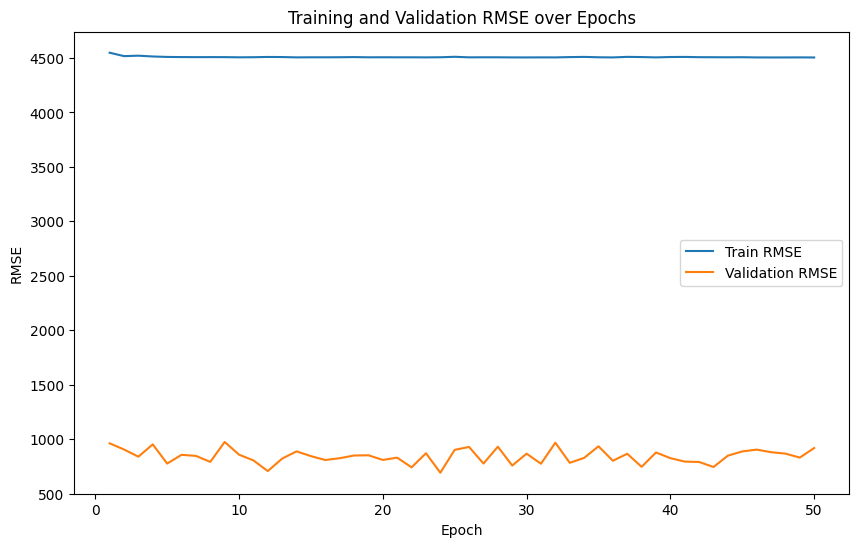

In [27]:
# Plotting training and validation RMSE
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_rmse_history, label='Train RMSE')
plt.plot(range(1, num_epochs+1), val_rmse_history, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE over Epochs')
plt.legend()
plt.show()